In [1]:
# a notebook for verifying DQN implementation
# + investigate how (well) it learns

# remember to install the Axelrod library before running the following code
# also, have a look on network.ipynb first

In [2]:
%load_ext autoreload
%autoreload 2

import gc
import numpy as np
import axelrod as axl  # https://axelrod.readthedocs.io/en/stable/index.html
from time import time
from pprint import pprint
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)

# the following imports are from network / axl_utils folder
import network
from axl_utils import NNplayer, State, set_match, set_play

In [3]:
C = axl.Action.C
D = axl.Action.D

# config game rules
# set_match & set_play function could be found inside axl_utils/game.py
GAME_LEN = 20
GAME = axl.Game(r=3, s=0, t=5, p=1)
Match = set_match(game=GAME, turns=GAME_LEN)
play = set_play(Match)

In [4]:
# the play function set up match between 2 players, print the result then return the match object
game = play(axl.Prober4(), axl.TitForTat())
game

[(3, 3), (3, 3), (5, 0), (0, 5), (5, 0), (1, 1), (1, 1), (0, 5), (3, 3), (5, 0), (0, 5), (5, 0), (0, 5), (3, 3), (5, 0), (0, 5), (5, 0), (1, 1), (0, 5)]
Player 1 score = 45
Player 2 score = 45


### Section 0: data

In [5]:
# an brief intro to the data

# State class could be found under axl_utils/nnplayer.py
# create a state container by
state = State(GAME_LEN, C=1, D=0.1, N=-1)
# the hyperparameters specify how we encode the environment
# '1' represent cooperation
# '0.1' represent defection
# '-1' means the turn has not happened yet

# this created a empty state that looks like this
current_state = state.values()
print("(1) current state")
print(current_state)


# assume we have a interaction between players, where we cooperated, and the opponent defected
# thus our action = C
# reward = 0 from the standard payoff matrix
action = C
reward = 0
# to record this interaction into the state:
state.push(C, D)

# updated state looks like this
next_state = state.values()
print("\n(2) next state")
print(next_state)
# New interactions are pushed to the *END* of the array
# this way the latest interaction is always fixed on the same positioin
# I hope this would help our algorithm to learn tit-for-tat


# Transition records what occured in the game, for our neural network to learn
# a Transition = (current_state, action, next_state, reward)
# so the above transition would be
from network.dqn import Transition
transition = Transition(current_state, action, next_state, reward, False)
print("\n(3) Transition")
print(transition)
# these form the data in this project


# a ReplayMemory is just a container to store the Transitions and feed to our neural network
memory = network.ReplayMemory(2)  # <- control the size
[memory.push(*transition) for i in '1234'];
print("\n(4) Memory")
print(memory)

# (check the code in axl_utils/nnplayer.py & network/dqn for details)

del memory, transition, Transition, current_state, action, next_state, reward

(1) current state
[[[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
  [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]]

(2) next state
[[[-1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.   1. ]
  [-1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.  -1.
   -1.  -1.  -1.  -1.  -1.   0.1]]]

(3) Transition
Transition(state=array([[[-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,
         -1, -1, -1, -1]]]), action=C, next_state=array([[[-1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ,
         -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ,  1. ],
        [-1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ,
         -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. , -1. ,  0.1]]]), reward=0, done=False)

(4) Memory
deque([Transition(state=array([[[-1, -1, -1, -1, -1,

### Section 1: DQN

In [6]:
# DQN class is inside network/dqn.py
# it defines how the network make decision + how it learns
# the implementation are not mentioned in this notebook
# please have a look at the .py file directly
# I've commented most of them

dqn = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            network.ReplayMemory(2000), gamma=0.9, greedy=0.2)

# NNplayer class is inside axl_utils/nnplayer.py
# it integrates our DQN with the axl library
# to allow it play under axl's environment

p1 = NNplayer(dqn, State(GAME_LEN))
del dqn
gc.collect()

param = {"lr": 1e-4, 'batch': 64, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

In [7]:
# 'with' statement makes my DQN enter test mode
# where its episilon-greedy is set to 0 (no random exploration)
# + printing our the estimated Q-value

with p1:
    players = (p1, axl.TitForTat())
    game = Match(players)
    game.play()
    
# initial Q_value predictions:

[[-1.919 -0.854]]
[[-1.933 -1.694]]
[[-2.171 -1.149]]
[[-1.988 -1.308]]
[[-1.934 -1.204]]
[[-0.998 -0.795]]
[[-1.433 -1.369]]
[[-1.835 -1.065]]
[[-1.983 -1.572]]
[[-1.553 -1.389]]
[[-1.328 -1.259]]
[[-1.523 -0.844]]
[[-1.181 -0.978]]
[[-1.043 -0.282]]
[[-0.608 -0.703]]
[[-0.052 -0.034]]
[[-0.272 -0.533]]
[[-0.306 -0.657]]
[[-0.445 -0.518]]
[[-0.087 -0.382]]


In [8]:
# collecting initial experience
# high greedy -> more random exploration

p1.network.greedy= 0.8
for i in range(60):
    players = (p1, axl.TitForTat())
    game = Match(players)
    game.play()
p1.network.greedy= 0.2

In [21]:
# theoritical Q values
# assuming the player cooperate til the last turn, then defect
# apply annuity formula with cashflow = 3.0, interest rate = 1/9, periods = 20 turns
# * the (1/9) come from our hyperparameter gamma, which is set to 0.9 by default
# then compensate the defection in 2nd last turn, and hard code the 21st turn to 0.0 (last turn must be 0 for DQN to learn)
true_Q = np.array([3.0/(1/9) * (1.0 - 1.0/(1.0+1/9)**(19-i)) + 5.0 for i in range(20)])
[print(f'{i:.2f}') for i in true_Q];

28.35
27.95
27.50
27.00
26.44
25.82
25.14
24.37
23.53
22.59
21.54
20.38
19.09
17.65
16.06
14.29
12.32
10.13
7.70
5.00


In [10]:
# training loop

score_ls = []
errors = []
for _ in range(20):
    start = time()
    
    # calling train method bound to NNplayer/DQN class
    # detailed documentation are in .py files
    p1.train(30, param)
    
    # collect new experience with the trained network
    [Match((p1, axl.TitForTat())).play() for _ in range(10)]
    
    print(f'loss: {p1.network.loss},            time: +{time()-start:.2f} sec')
    
    # calculating Q-value error for later use
    # a bit tedious here but I'm too lazy to fix
    values = []
    state = State(GAME_LEN)
    for i in range(20):
        value = p1.network(state.values())[0]
        if i != 19:
            values.append(value[0])
        else:
            values.append(value[1])  # defection on 20th turn
        state.push(C, C) 
    error = true_Q - np.array(values)
    errors.append(error)


# left: running loss for cooperation
# right: running loss for defection

loss: [0.284 0.289],            time: +3.63 sec
loss: [0.195 0.167],            time: +4.78 sec
loss: [0.123 0.106],            time: +4.48 sec
loss: [0.08  0.078],            time: +4.94 sec
loss: [0.063 0.06 ],            time: +5.03 sec
loss: [0.051 0.055],            time: +5.54 sec
loss: [0.041 0.042],            time: +12.78 sec
loss: [0.028 0.031],            time: +5.39 sec
loss: [0.025 0.027],            time: +4.98 sec
loss: [0.023 0.025],            time: +4.64 sec
loss: [0.024 0.033],            time: +4.40 sec
loss: [0.024 0.044],            time: +4.40 sec
loss: [0.019 0.027],            time: +4.35 sec
loss: [0.017 0.024],            time: +4.29 sec
loss: [0.019 0.028],            time: +4.35 sec
loss: [0.026 0.03 ],            time: +4.35 sec
loss: [0.017 0.026],            time: +4.38 sec
loss: [0.014 0.029],            time: +4.36 sec
loss: [0.013 0.022],            time: +4.51 sec
loss: [0.013 0.018],            time: +4.35 sec


In [11]:
with p1:
    play(p1, axl.TitForTat())
# predicted Q-values after training:

# * 21st turn is dropped by my 'play' function
# because our DQN cannot learn it
# so the following results are for a 20 turn IPD

[[26.67  25.998]]
[[26.328 25.711]]
[[25.849 25.176]]
[[25.392 24.678]]
[[24.836 24.121]]
[[24.245 23.527]]
[[23.643 22.894]]
[[22.97  22.327]]
[[22.118 21.432]]
[[21.262 20.577]]
[[20.271 19.541]]
[[19.301 18.466]]
[[18.033 17.314]]
[[16.716 16.046]]
[[15.205 14.519]]
[[13.588 12.941]]
[[11.756 11.182]]
[[9.694 9.033]]
[[7.466 5.881]]
[[3.02  5.051]]
[(3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3), (3, 3)]
Player 1 score = 57
Player 2 score = 57


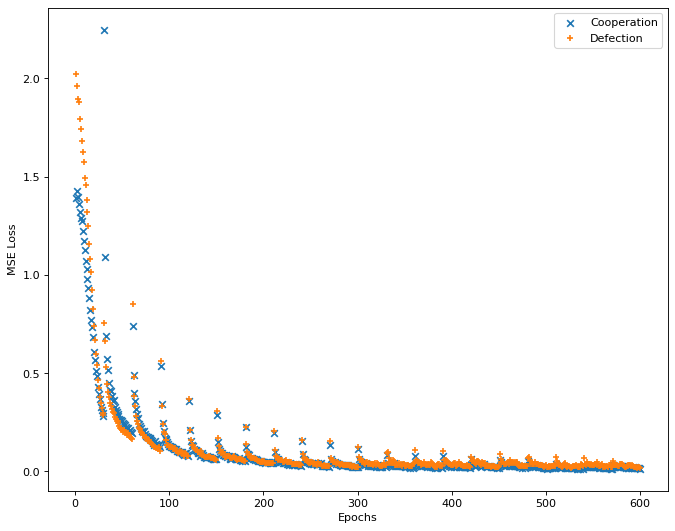

In [12]:
# training loss
# the beauty of double DQN
p1.plot()

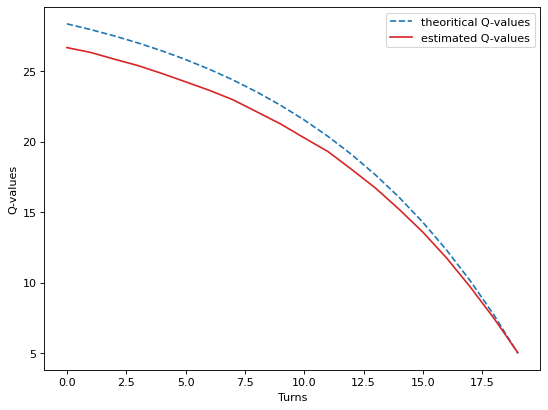

In [22]:
# visualize how fit our estimated Q-values is compared to theoretical values
plt.figure(figsize=(8, 6), dpi=80)
plt.plot(range(20), true_Q, '--', c='tab:blue', label='theoritical Q-values')
plt.plot(range(20), values, c='tab:red', label='estimated Q-values')
plt.xlabel('Turns')
plt.ylabel('Q-values')
plt.legend(loc='upper right')
plt.show()

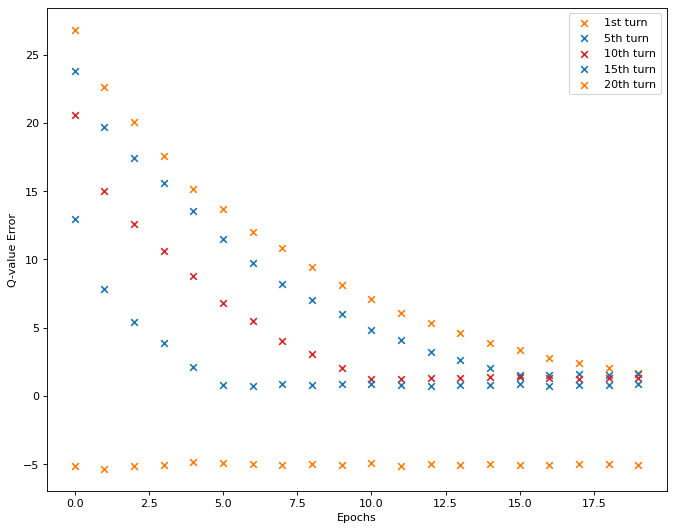

In [14]:
# visualizing the recursion nature of Bellman's equation,
# where the later states has to be learnt prior to learning preceding states

# plotting the error between our prediction against the theoritical Q-value
errors = np.array(errors)
plt.figure(figsize=(10, 8), dpi=80)
plt.scatter(range(len(errors)), errors[:,0], c='tab:orange', marker='x', label='1st turn')
plt.scatter(range(len(errors)), errors[:,4], c='tab:blue', marker='x', label='5th turn')
plt.scatter(range(len(errors)), errors[:,9], c='tab:red', marker='x', label='10th turn')
plt.scatter(range(len(errors)), errors[:,14], c='tab:blue', marker='x', label='15th turn')
plt.scatter(range(len(errors)), errors[:,19], c='tab:orange', marker='x', label='20th turn')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Q-value Error')
plt.show()

# due to the recursion
# V(current) is dependent on V(next)
# meaning that 1st turn will not be correctly learnt until the 2nd got the right value
# resulting in the gaps below

# this is similar to how tabular Q learning works via dynamic programming

### Section 2: DQN without fixed target (single DQN)

In [15]:
dqn2 = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            network.ReplayMemory(2000), gamma=0.9, greedy=0.2)
p2 = NNplayer(dqn2, State(GAME_LEN))
del dqn2
gc.collect()

param = {"lr": 1e-4, 'batch': 64, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

p2.set_greedy(0.8)
for i in range(60):
    players = (p2, axl.TitForTat())
    game = Match(players)
    game.play()
p2.set_greedy(0.2)

for _ in range(100):
    start = time()
    
    p2.train(1, param)  # my train function updates target net at the end via deepcopy, we can overwrite this by
    p2.network.target_net = p2.network.policy_net  # shallow copy policy net to target net
    
    [Match((p2, axl.TitForTat())).play() for _ in range(10)]
    print(f'loss: {p2.network.loss},            time: +{time()-start:.2f} sec')

loss: [1.473 4.65 ],            time: +0.30 sec
loss: [1.843 5.026],            time: +0.32 sec
loss: [1.85  4.658],            time: +0.34 sec
loss: [1.869 4.381],            time: +0.35 sec
loss: [1.815 4.027],            time: +0.37 sec
loss: [1.77  3.897],            time: +0.36 sec
loss: [1.781 3.23 ],            time: +0.37 sec
loss: [1.877 3.114],            time: +0.37 sec
loss: [1.873 2.667],            time: +0.39 sec
loss: [1.958 2.64 ],            time: +0.37 sec
loss: [2.212 2.484],            time: +0.37 sec
loss: [2.415 2.65 ],            time: +0.37 sec
loss: [2.733 2.82 ],            time: +0.36 sec
loss: [3.122 2.986],            time: +0.40 sec
loss: [3.392 3.189],            time: +0.45 sec
loss: [3.743 3.647],            time: +0.38 sec
loss: [4.206 4.038],            time: +0.47 sec
loss: [4.835 4.718],            time: +0.48 sec
loss: [5.21  5.667],            time: +0.39 sec
loss: [6.193 6.533],            time: +0.43 sec
loss: [6.976 7.726],            time: +0

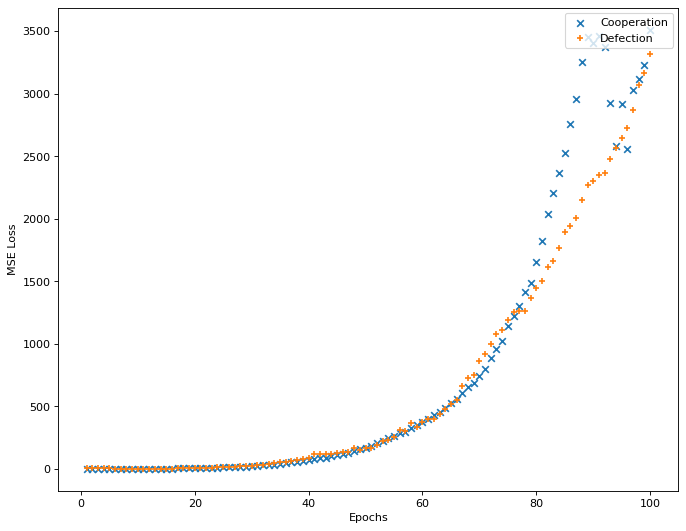

In [16]:
# see how loss grows exponentially without fixed target
p2.plot()

In [17]:
# result:
with p2:
    play(p2, axl.TitForTat())
    
# incorrect Q-values -> bad/random policy
# (run this section serveral time to see how the policy is effectively random)

[[1895.781 2224.981]]
[[4509.652 4849.993]]
[[-2325.622 -1951.222]]
[[5065.524 5399.772]]
[[-1253.18   -831.701]]
[[1857.644 2253.477]]
[[2749.836 3138.486]]
[[2115.037 2519.162]]
[[-126.599  294.846]]
[[1711.601 2097.568]]
[[2462.761 2878.531]]
[[-2544.518 -2109.69 ]]
[[4786.542 5144.551]]
[[-1133.749  -719.015]]
[[ 790.844 1146.44 ]]
[[1524.503 1815.945]]
[[3151.942 3363.987]]
[[-685.803 -440.333]]
[[1103.357 1251.631]]
[[-73.823  11.889]]
[(5, 0), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1), (1, 1)]
Player 1 score = 23
Player 2 score = 18


In [18]:
del p2

### Section 3: testing the off-policyness

In [19]:
from axl_utils.extract import extract

In [20]:
# collecting experience from axl.Random
memory = network.ReplayMemory(10000)
for _ in range(500):
    game = play(axl.Random(), axl.TitForTat(), show=False)
    extract(game, memory)
    
print(len(memory))
# we can then pass this memory into a fresh DQN

TypeError: __new__() missing 1 required positional argument: 'done'

In [ ]:
dqn3 = network.DQN([
                    network.Flatten_layer(),
                    network.Linear_layer(GAME_LEN*2, 100, bias=0.01),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 200),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(200, 100),
                    network.Activation_layer('ReLU'),
                    network.Linear_layer(100, 2),
                    ],
            memory, gamma=0.9, greedy=0.2)  # <- feeding the memory from above
p3 = NNplayer(dqn3, State(GAME_LEN))
del dqn3
gc.collect()

param = {"lr": 1e-4, 'batch': 64, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

In [ ]:
for _ in range(20):
    start = time()
    p3.train(5, param)
    print(f'loss: {p3.network.loss},            time: +{time()-start:.2f} sec')

In [ ]:
with p3:
    play(p3, axl.TitForTat())
    
# learns well, without ever playing the game

In [ ]:
del p3

### Section 4: but what did it learn?

In [ ]:
# might be an obvious question but let's see what happens if our DQN meets provocative defection

p1.network.greedy = 0.0
play(p1, axl.HardProber());  # hard prober defects forever if its opponent does not retaliate

In [ ]:
play(axl.Cooperator(), axl.HardProber());  # => our DQN is basically a naive cooperator

In [ ]:
play(axl.TitForTat(), axl.HardProber());  # while TFT can generalize well to any opponent

In [ ]:
# => continue exploration on Stage 2

### Section 5: learning TFT with 2 perceptrons

In [ ]:
# possible states of last turn
# where [1,1] means mutual cooperation
last_turn = np.array([[1,1],[0,1],[1,0],[0,0]])

# target
# => copy opponent's action
action = np.array([[1],[1],[0],[0]])

nn = network.NeuralNetwork([network.Linear_layer(2, 1)])
param = {"lr": 3e-2, 'batch': 2, "mode": "train", "eps": 1e-16, "epoch": 0, 't': 1, 'clip': 1.0,
         'optimizer': ('Adam', 0.9, 0.999), 'regularizer': None, "loss_fn":"mse"}

In [ ]:
for i in range(40):
    nn.train(last_turn, action, param)
    action_ = np.round(nn(last_turn))
    accuracy = np.sum(action_==action) / len(action)
    print(f"Epoch {i}, Accuracy = {accuracy}")

In [ ]:
# but obviously this is human-learning instead of machine learning
# will the DQN figure this out by itself?

# also, the architecture is more of a policy-gradient approach
# the regression nature of DQNs make it impossible to employ simple architecture